# Inspection of WEAVE first-light supercubes

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u


## 2. Read data

### select one dataset:

In [2]:
dataset = 1

In [3]:
plots = False

In [4]:
plots = True

Red arm:

In [5]:
if dataset == 1:
    hdu = fits.open('data/supercube_2963103-002.fit')

In [6]:
hdu.info()
wcs = WCS(hdu[1].header)
wavelength = wcs.spectral.pixel_to_world(np.arange(hdu[1].data.shape[0])).to_value(u.Angstrom)
sensitivity_function = hdu[5].data

Filename: data/supercube_2963103-002.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     468   ()      
  1  BLUE_DATA     1 ImageHDU        72   (176, 188, 4581)   float32   
  2  BLUE_IVAR     1 ImageHDU        72   (176, 188, 4581)   float32   
  3  BLUE_DATA_NOSS    1 ImageHDU        72   (176, 188, 4581)   float32   
  4  BLUE_IVAR_NOSS    1 ImageHDU        72   (176, 188, 4581)   float32   
  5  BLUE_SENSFUNC    1 ImageHDU        15   (4581,)   float32   
  6  BLUE_DATA_COLLAPSE3    1 ImageHDU        72   (176, 188)   float32   
  7  BLUE_IVAR_COLLAPSE3    1 ImageHDU        72   (176, 188)   float32   


### explore counts to define bright, medium, and faint regions:

In [7]:
mean_counts = np.nanmean(hdu[1].data, axis=0)  # same as hdu[6]
median_counts = np.nanmedian(hdu[1].data, axis=0)

mean_sky_map = np.nanmean(hdu[3].data-hdu[1].data, axis=0)
median_sky_map = np.nanmedian(hdu[3].data-hdu[1].data, axis=0)

mask_bright = mean_counts > mean_sky_map
mask_medium = (median_counts > median_sky_map) & (mean_counts <= mean_sky_map)
mask_faint = (mean_counts > 0) & (median_counts <= median_sky_map)
mask_all = mean_counts > 0

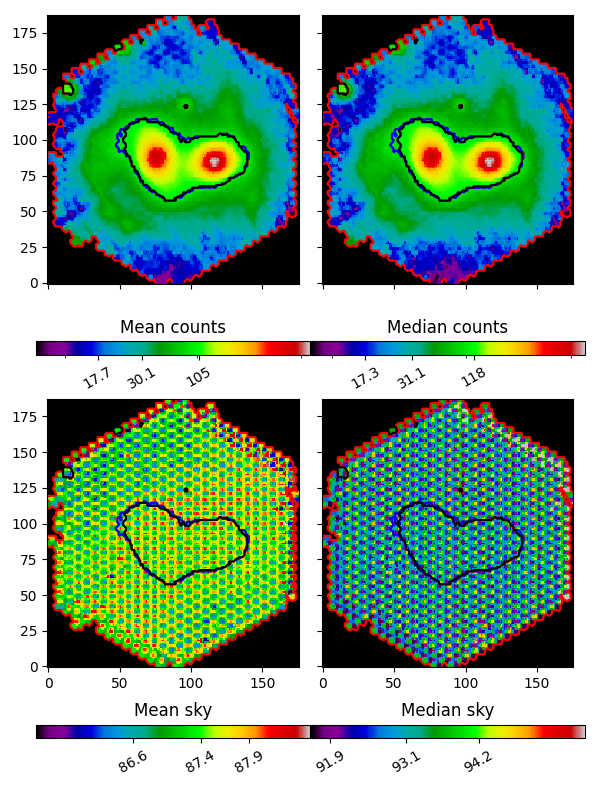

In [8]:
if plots:
    plt.close('counts')
    fig = plt.figure('counts', figsize=(6, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    
    def show_data(data, ax, title):
        p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
        im = ax.imshow(data,
                       interpolation='nearest', origin='lower',
                       cmap='nipy_spectral',
                       norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                      )
        ax.contour(mask_faint, levels=[0.5], colors=['r'])
        ax.contour(mask_medium, levels=[0.5], colors=['b'])
        ax.contour(mask_bright, levels=[0.5], colors=['k'])
        cb = fig.colorbar(im, ax=ax, orientation='horizontal')
        cb.ax.set_title(title)
        cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)
        
    show_data(mean_counts, ax[0, 0], 'Mean counts')
    show_data(median_counts, ax[0, 1], 'Median counts')
    show_data(mean_sky_map, ax[1, 0], 'Mean sky')
    show_data(median_sky_map, ax[1, 1], 'Median sky')
    
    plt.show()

### average SED within each region:

In [9]:
datacube = (hdu[3].data - hdu[1].data) * sensitivity_function[:, np.newaxis, np.newaxis]
sky_bright = np.nansum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
sky_medium = np.nansum(datacube*mask_medium[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_medium)
sky_faint = np.nansum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
sky_all = np.nansum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)

In [10]:
datacube = hdu[1].data * sensitivity_function[:, np.newaxis, np.newaxis]
SED_bright = np.nansum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_medium = np.nansum(datacube*mask_medium[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_medium, )
SED_faint = np.nansum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)

### broadband colors:

In [11]:
class Filter(object):
    
    def __init__(self, filename, col_wavelength=0, col_response=1):
        self.wavelength, self.response = np.loadtxt(filename, usecols=(col_wavelength, col_response), unpack=True)        
        #self.norm_AB =  np.trapz(3631/3.34e4 * self.response/self.wavelength, self.wavelength)
        self.pivot_wavelength =  np.sqrt(
            np.trapz(self.response, self.wavelength) / np.trapz(self.response/self.wavelength**2, self.wavelength))
        
    def m_AB(self, wavelength, F_lambda):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(wavelength*F_lambda*response, wavelength) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

    def m_AB_cube(self, wavelength, F_lambda_cube):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(F_lambda_cube*(wavelength*response)[:, np.newaxis, np.newaxis], wavelength, axis=0) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

g_filter = Filter('sdss-filters/g.dat', 0, 2)
r_filter = Filter('sdss-filters/r.dat', 0, 2)
i_filter = Filter('sdss-filters/i.dat', 0, 2)
z_filter = Filter('sdss-filters/z.dat', 0, 2)

In [12]:
g_map = g_filter.m_AB_cube(wavelength, datacube)
r_map = r_filter.m_AB_cube(wavelength, datacube)


/tmp/ipykernel_606343/409879002.py:18: RuntimeWarning: divide by zero encountered in log10
  return -2.5*np.log10(
/tmp/ipykernel_606343/409879002.py:18: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(


/tmp/ipykernel_606343/294331592.py:29: RuntimeWarning: invalid value encountered in subtract
  show_data(g_map-r_map, ax[0, 2], '(g-r)', cmap, 0, 1)


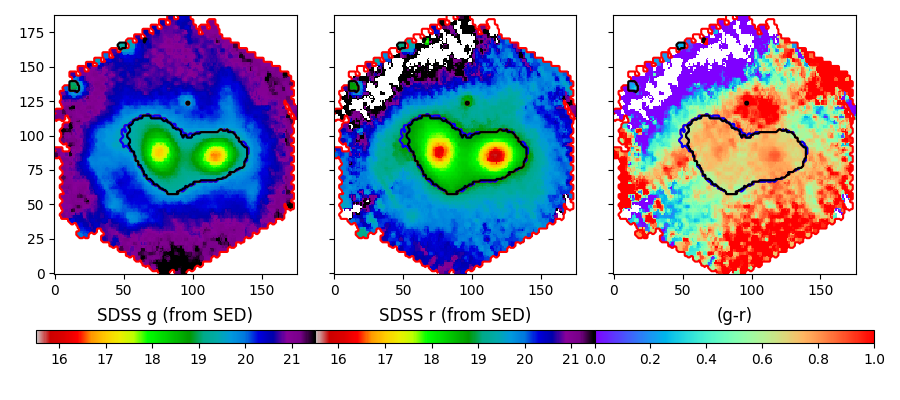

In [13]:
if plots:
    plt.close('broadband')
    fig = plt.figure('broadband', figsize=(9, 4))
    ax = fig.subplots(nrows=1, ncols=3, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    
    def show_data(data, ax, title, cmap, vmin, vmax):
        #p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
        im = ax.imshow(data,
                       interpolation='nearest', origin='lower',
                       cmap=cmap, vmin=vmin, vmax=vmax,
#                       norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                      )
        ax.contour(mask_faint, levels=[0.5], colors=['r'])
        ax.contour(mask_medium, levels=[0.5], colors=['b'])
        ax.contour(mask_bright, levels=[0.5], colors=['k'])
        cb = fig.colorbar(im, ax=ax, orientation='horizontal')
        cb.ax.set_title(title)
        #cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)
        
    cmap = 'nipy_spectral_r'; vmin = 15.5; vmax = 21.5
    show_data(g_map, ax[0, 0], 'SDSS g (from SED)', cmap, vmin, vmax)
    show_data(r_map, ax[0, 1], 'SDSS r (from SED)', cmap, vmin, vmax)
    cmap = 'rainbow'
    show_data(g_map-r_map, ax[0, 2], '(g-r)', cmap, 0, 1)

    plt.show()

## 3. Spectrophotometric calibration:

In [14]:
g_bright = g_filter.m_AB(wavelength, SED_bright)
r_bright = r_filter.m_AB(wavelength, SED_bright)
g_medium = g_filter.m_AB(wavelength, SED_medium)
r_medium = r_filter.m_AB(wavelength, SED_medium)
g_faint = g_filter.m_AB(wavelength, SED_faint)
r_faint = r_filter.m_AB(wavelength, SED_faint)


In [15]:
lines = {}

lines['OII_3726'] = [3726.032, 3717.0, 3737.0]
lines['OII_3729'] = [3728.815, 3717.0, 3737.0]
lines['NeIII_3869'] = [3869.060, 3859.0, 3879.0]
lines['H_delta'] = [4101.734, 4092.0, 4111.0]
lines['H_gamma'] = [4340.464, 4330.0, 4350.0]
lines['OIII_4363'] = [4363.210, 4350.0, 4378.0]
lines['H_beta'] = [4861.325, 4851.0, 4871.0]
lines['OIII_4959'] = [4958.911, 4949.0, 4969.0]
lines['OIII_5007'] = [5006.843, 4997.0, 5017.0]

# NGC 7318
redshift_a = 6630/3e5
redshift_b = 5774/3e5


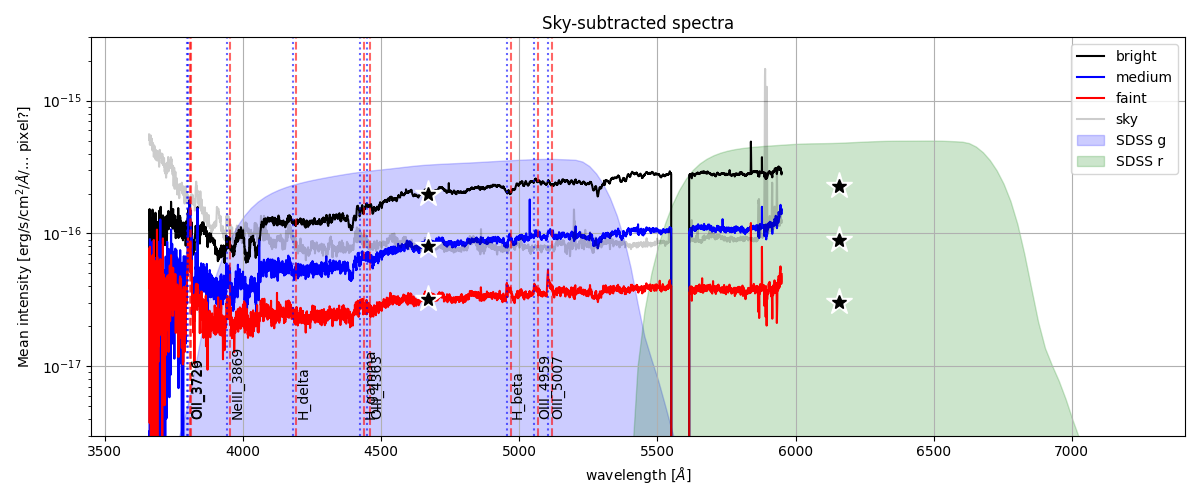

In [16]:
if plots:
    plt.close('spectra')
    fig = plt.figure('spectra', figsize=(12, 5))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    ax[0, 0].set_title(r'Sky-subtracted spectra')
    ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')
    ax[0, 0].plot(wavelength, SED_bright, 'k-', label='bright')
    ax[0, 0].plot(wavelength, SED_medium, 'b-', label='medium')
    ax[0, 0].plot(wavelength, SED_faint, 'r-', label='faint')
    ax[0, 0].plot(wavelength, sky_all, 'k-', alpha=.2, label='sky')
    ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
    ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')

    ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_medium)/g_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_medium)/g_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_medium)/r_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_medium)/r_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

    ax[0, 0].legend()

    #ax[0, 1].set_title(r'Sky')
    #ax[0, 1].plot(wavelength, sky_bright, c='k', alpha=.2, label='bright')
    #ax[0, 1].plot(wavelength, sky_medium, c='b', alpha=.2, label='medium')
    #ax[0, 1].plot(wavelength, sky_faint, c='r', alpha=.2, label='faint')
    #ax[0, 1].plot(wavelength, sky_all, c='g', alpha=.2, label='all')
    #ax[0, 1].legend()
    
    ax[0, -1].set_yscale('log')
    ax[0, -1].set_ylim(3e-18, 3e-15)
    ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
#    ax[-1, -1].set_xlim(5450, 9550)
    #ax[-1, 1].set_xlabel(r'wavelength [$\AA$]')

    for line in lines:
        ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
        ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
        ymin, ymax = ax[0, 0].get_ylim()
        ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
        #print(lines[line][0]*(1+redshift_a), ymin, line)

    ax[0, 0].grid()
    plt.show()

In [17]:
g_bright, g_medium, g_faint

(18.501685978984746, 19.47647308520892, 20.470938698068004)

In [18]:
r_bright, r_medium, r_faint

(17.74957727694458, 18.771161012598295, 19.930490384488312)

In [19]:
wavelength_bins = np.array([4050, 4250, 3850, 3950])
indices_D4000_a = np.searchsorted(wavelength, wavelength_bins*(1+redshift_a))
indices_D4000_b = np.searchsorted(wavelength, wavelength_bins*(1+redshift_b))


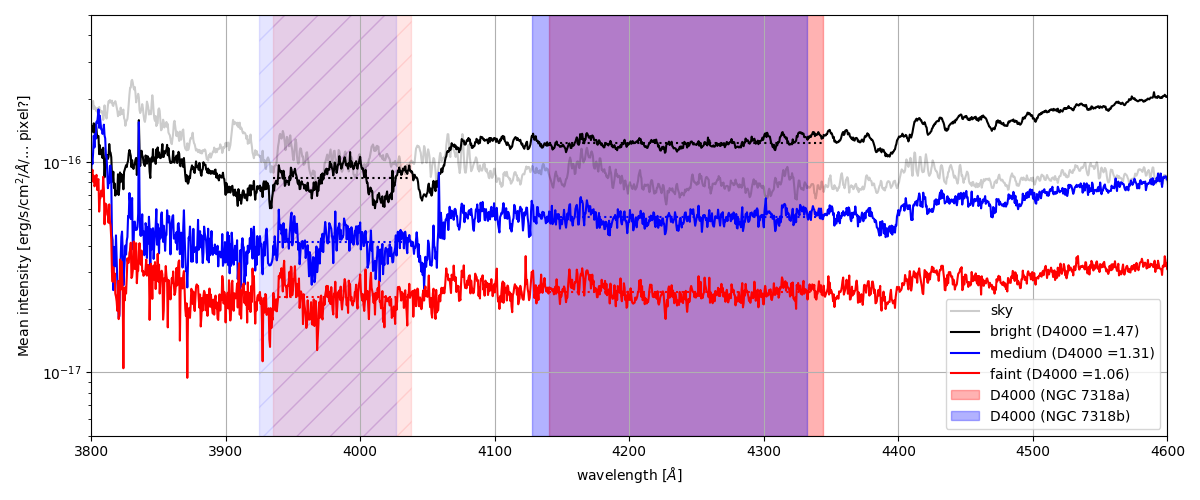

In [20]:
if plots:
    plt.close('D4000 spectrum')
    fig = plt.figure('D4000 spectrum', figsize=(12, 5))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

    ax[0, 0].plot(wavelength, sky_all, 'k-', alpha=.2, label='sky')

    red = np.nanmean(SED_bright[indices_D4000_a[0]:indices_D4000_a[1]])
    blue = np.nanmean(SED_bright[indices_D4000_a[2]:indices_D4000_a[3]])
    ax[0, 0].plot([wavelength[indices_D4000_a][0], wavelength[indices_D4000_a][1]], [red, red], 'k:')
    ax[0, 0].plot([wavelength[indices_D4000_a][2], wavelength[indices_D4000_a][3]], [blue, blue], 'k:')
    ax[0, 0].plot(wavelength, SED_bright, 'k-', label=f'bright (D4000 ={red/blue:.2f})')

    red = np.nanmean(SED_medium[indices_D4000_a[0]:indices_D4000_a[1]])
    blue = np.nanmean(SED_medium[indices_D4000_a[2]:indices_D4000_a[3]])
    ax[0, 0].plot([wavelength[indices_D4000_a][0], wavelength[indices_D4000_a][1]], [red, red], 'b:')
    ax[0, 0].plot([wavelength[indices_D4000_a][2], wavelength[indices_D4000_a][3]], [blue, blue], 'b:')
    ax[0, 0].plot(wavelength, SED_medium, 'b-', label=f'medium (D4000 ={red/blue:.2f})')

    red = np.nanmean(SED_faint[indices_D4000_a[0]:indices_D4000_a[1]])
    blue = np.nanmean(SED_faint[indices_D4000_a[2]:indices_D4000_a[3]])
    ax[0, 0].plot([wavelength[indices_D4000_a][0], wavelength[indices_D4000_a][1]], [red, red], 'r:')
    ax[0, 0].plot([wavelength[indices_D4000_a][2], wavelength[indices_D4000_a][3]], [blue, blue], 'r:')
    ax[0, 0].plot(wavelength, SED_faint, 'r-', label=f'faint (D4000 ={red/blue:.2f})')

    ax[0, -1].set_yscale('log')
    ax[0, -1].set_ylim(5e-18, 5e-16)
    ax[0, -1].set_xlim(3800, 4600)
    ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
    #ax[-1, 1].set_xlabel(r'wavelength [$\AA$]')

    ax[0, 0].axvspan(wavelength[indices_D4000_a][0], wavelength[indices_D4000_a][1], color='r', alpha=.3, label='D4000 (NGC 7318a)')
    ax[0, 0].axvspan(wavelength[indices_D4000_a][2], wavelength[indices_D4000_a][3], color='r', alpha=.1, hatch='/')
    ax[0, 0].axvspan(wavelength[indices_D4000_b][0], wavelength[indices_D4000_b][1], color='b', alpha=.3, label='D4000 (NGC 7318b)')
    ax[0, 0].axvspan(wavelength[indices_D4000_b][2], wavelength[indices_D4000_b][3], color='b', alpha=.1, hatch='/')
    

    ax[0, 0].grid()
    ax[0, 0].legend()
    plt.show()

In [21]:
red = np.nanmean(datacube[indices_D4000_a[0]:indices_D4000_a[1], :, :], axis=0)
blue = np.nanmean(datacube[indices_D4000_a[2]:indices_D4000_a[3], :, :], axis=0)
D4000_map_a = red / blue

/tmp/ipykernel_606343/2852244572.py:3: RuntimeWarning: invalid value encountered in true_divide
  D4000_map_a = red / blue


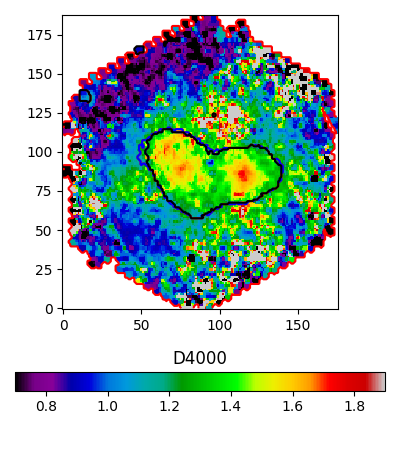

In [22]:
if plots:
    plt.close('H_alpha map')
    fig = plt.figure('H_alpha map', figsize=(4, 4.5))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    def show_data(data, ax, title):
#        p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
        im = ax.imshow(data,
                       interpolation='nearest', origin='lower',
                       cmap='nipy_spectral',
                       vmin=0.7, vmax=1.9,
#                       norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                      )
        ax.contour(mask_faint, levels=[0.5], colors=['r'])
        ax.contour(mask_medium, levels=[0.5], colors=['b'])
        ax.contour(mask_bright, levels=[0.5], colors=['k'])
        cb = fig.colorbar(im, ax=ax, orientation='horizontal')
        cb.ax.set_title(title)
#        cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)

    #show_data(continuum, ax[0, 0], r'H$\alpha$ continuum intensity [erg/s/cm$^2/\AA$/...]')
    show_data(D4000_map_a, ax[0, 0], r'D4000')
    #show_data(Ha_map_b, ax[0, 2], r'EW(H$\alpha$) [$\AA$] (NGC 7381b)')

    plt.show()

In [23]:
wcs.pixel_scale_matrix[0, 0]*3600

-0.5000000000000004